# Product Interest Analysis - AT&T

by `Xiaoli Qiu`

created: `2021-12-07`

This notebook gauges the correlation/association between product interest and conversion for ATT. (Data on CTL not yet available at the time of this analysis.) Date ranges for the data retrieved: ['2021-08-01', '2021-11-30']. 

JIRA: https://clearlink.atlassian.net/browse/ONE-7690. <br>


A list of relevant route_ids:

- 727 Product Interest Internet
- 728 Product Interest TV
- 729 Product Interest Bundles
- 730 Product Interest Wireless
- 786 Product Interest Phone

## Contents
1. <a href='#histograms'> Histograms </a>
2. <a href='#chi_square'> Chi-Square Test </a>
3. <a href='#conclusion'> Conclusion </a>

In [2]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2021-12-13 08:14:35.484437


In [3]:
import pandas as pd
import numpy as np 

In [4]:
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency 
from scipy.stats import chi2 as chi2_2

In [5]:
import plotly.express as px
import plotly.io as pio

import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [6]:
#style definition
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("hls")
# sns.set_style("whitegrid")

import matplotlib.pyplot as plt  
%matplotlib inline
plt.style.use('dark_background')

pio.templates.default = "plotly_dark"

In [7]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. 
    The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [9]:
import psycopg2

In [10]:
# Connect to DW_prod
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# Connect to DW_stage (comment the 2 lines above and un-commnet the two below)
# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

In [11]:
get_product_info = """
SELECT cd.date_prequeue, cdr.contact_id, cd.brand_skilled,
       cd.max_speed_qual, cd.intent_lookup_flag, cd.consent_flag,
       cd.is_converted,
       LISTAGG(DISTINCT lc.description, ',') AS product_menu
FROM data_warehouse.call_detail_attribute_log cd
LEFT JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cd.contact_id =  cdr.contact_id
LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lc ON lc.id = cdr.lookup_cd_ivr_route_ids_id
WHERE lookup_cd_ivr_route_ids_id IN (727, 728, 729, 730, 786)
AND cd.brand_skilled IN ('ATT')
AND DATE(cd.date_prequeue) BETWEEN '{start_date}' AND '{end_date}'
AND cd.call_conclusion = 'Answered'
GROUP BY cd.date_prequeue, cdr.contact_id, cd.brand_skilled, cd.max_speed_qual,
         cd.intent_lookup_flag, cd.consent_flag, cd.is_converted
ORDER BY cdr.contact_id;

"""

In [12]:
df = pd.read_sql_query(get_product_info.format(start_date='2021-08-01', end_date='2021-11-30'), con)

In [45]:
# Once you have run the above, you can choose to save the data by un-commenting the blow, 
# and do read_pickle the next time (un-comment the next cell) without connecting to DB and do read_sql_query again (by commenting the 5 cells above).

# df.to_pickle('ProductInterest_ATT_Aug1_to_Nov30.pkl')

In [14]:
# df = pd.read_pickle('ProductInterest_ATT_Aug1_to_Nov30.pkl')

In [15]:
df

date_prequeue    contact_id brand_skilled max_speed_qual  \
0       2021-08-05  134040129955           ATT             NA   
1       2021-08-05  134040132313           ATT             NA   
2       2021-08-05  134040141697           ATT             NA   
3       2021-08-05  134040145631           ATT             NA   
4       2021-08-05  134040150233           ATT             NA   
...            ...           ...           ...            ...   
6809    2021-11-30  193405924405           ATT             NA   
6810    2021-11-30  193405929738           ATT             25   
6811    2021-11-30  193405951775           ATT           1000   
6812    2021-11-30  193405953299           ATT             NA   
6813    2021-11-30  193405958956           ATT              0   

      intent_lookup_flag  consent_flag  is_converted  \
0                      2             1             0   
1                      2             1             0   
2                      2             1             0   
3                      1             1             0   
4                      2             1             0   
...                  ...           ...           ...   
6809                   1             1             0   
6810                   2             1             1   
6811                   1             1             1   
6812                   1             0             0   
6813                   2             1             0   

                   product_menu  
0     Product Interest Internet  
1     Product Interest Internet  
2     Product Interest Internet  
3     Product Interest Internet  
4      Product Interest Bundles  
...                         ...  
6809  Product Interest Internet  
6810  Product Interest Internet  
6811  Product Interest Internet  
6812        Product Interest TV  
6813        Product Interest TV  

[6814 rows x 8 columns]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6814 entries, 0 to 6813
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date_prequeue       6814 non-null   object
 1   contact_id          6814 non-null   int64 
 2   brand_skilled       6814 non-null   object
 3   max_speed_qual      6814 non-null   object
 4   intent_lookup_flag  6814 non-null   int64 
 5   consent_flag        6814 non-null   int64 
 6   is_converted        6814 non-null   int64 
 7   product_menu        6814 non-null   object
dtypes: int64(4), object(4)
memory usage: 426.0+ KB


In [17]:
df[(df['product_menu'].str.contains(','))]['product_menu'].unique()

array(['Product Interest Phone,Product Interest Wireless,Product Interest TV,Product Interest Internet',
       'Product Interest Phone,Product Interest Bundles,Product Interest Internet',
       'Product Interest TV,Product Interest Bundles,Product Interest Internet',
       'Product Interest Phone,Product Interest TV,Product Interest Bundles,Product Interest Internet',
       'Product Interest TV,Product Interest Internet',
       'Product Interest Phone,Product Interest TV,Product Interest Internet',
       'Product Interest Phone,Product Interest Internet'], dtype=object)

In [18]:
len(df[(df['product_menu'].str.contains(','))]) == len(df[(df['product_menu'].str.contains(','))&(df['product_menu'].str.contains('Internet'))])

True

__Observations:__

For the calls that have multiple product interests, all of them contains an interest in internet. 

In [19]:
# Whether 727 Product Interest Internet is in the route_ids
df['internet'] = df.apply(lambda x: 1 if 'Internet' in x['product_menu'] else 0, axis=1)

In [20]:
# Adding a column indicating whether a call has multiple product interests (internet being one of them)
# 1 meaning the call has multiple product interests and 727 Product Interest Internet is one of the intersts, 0 otherwise
df['products'] = df.apply(lambda x: 1 if 'Internet' in x['product_menu'] and  ',' in x['product_menu'] else 0, axis=1)

In [21]:
product_map = {'Internet': 1, 'Wireless': 2, 'TV': 3, 'Phone': 4, 'Bundles': 5}
x = df.product_menu.str.split(expand=True)
df['product'] = None
df['product'] = df['product'].fillna(x[x.isin(product_map.keys())]\
                                     .ffill(axis=1).bfill(axis=1).iloc[:, 0])
df['product'].replace(product_map, inplace=True)
# For those calls where internet is one of the product interests, use internet
df.loc[(df['internet']==1)&(df['products']==1), 'product'] = 1

<a id='histograms'> </a>

# Histograms

In [22]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=df['product'],  histnorm='probability density'))

fig.update_layout(title='Histogram of Product Interest',
                  xaxis_title='Product', 
                  yaxis_title='Probability Density',
                  xaxis = dict(
                      tickmode = 'array',
                      tickvals = [1, 2, 3, 4, 5],
                      ticktext = ['Internet', 'Wireless', 'TV', 'Phone', 'Bundles'])
                 )
                  

fig.show()

__Observations:__

~82% of calls have an interst in 'Internet'. ~12% in TV. Others are only a few. 

In [30]:
data = df

fig = px.histogram(data, x="is_converted", facet_col="product", histnorm='probability density')
fig.update_layout(title='Product Interest vs Conversion')
fig.show()

__Note:__
- `product_map = {'Internet': 1, 'Wireless': 2, 'TV': 3, 'Phone': 4, 'Bundles': 5}`
- The histograms are normalized within each product category, i.e., the probability density should add up to 1 for each product category (each column in the plot). <br>

__Observations:__ <br>
Those who are interested in internet seem more likely to convert than the rest.

In [31]:
data = df

fig = px.histogram(data, x="is_converted", facet_col="internet", histnorm='probability density')
fig.update_layout(title='Product Interest (Internet or not) vs Conversion')
fig.show()

__TL;DR:__ <br>
- For those interested in internet, they're more likely to convert than those who don't. 
- However, ~82% of the samples shows an interest in internet.

<a id='chi_square'> </a>

# Chi-Square Test

Use chi-square statistic to show whether or not there is a relationship between product and conversion. 

In [23]:
[resultant_chi, resultant_p] = chi_square_test(df[['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'is_converted', 'product']])

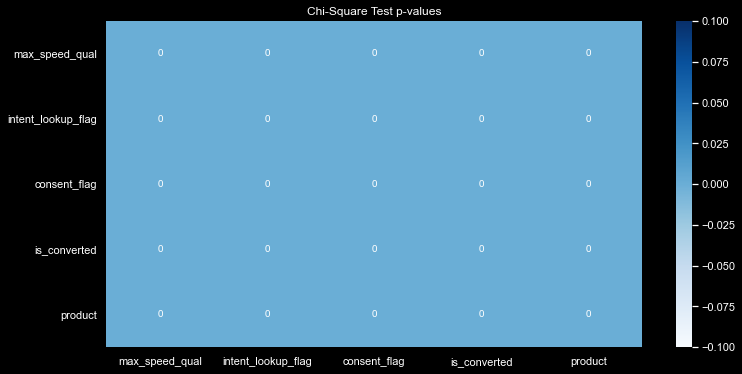

In [24]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

p-values are all good. Only need to examine chi-values, large chi-value indicates that the two variables are associated. 

One __caveat__ being chi-values are not like Pearson-correlation where 1 and -1 means perfect positive correlation and perfect negative correlation respectively, chi-square only tells us whether the variables are independent, it is unbounded and does not have a relative measure for the strength of association. 

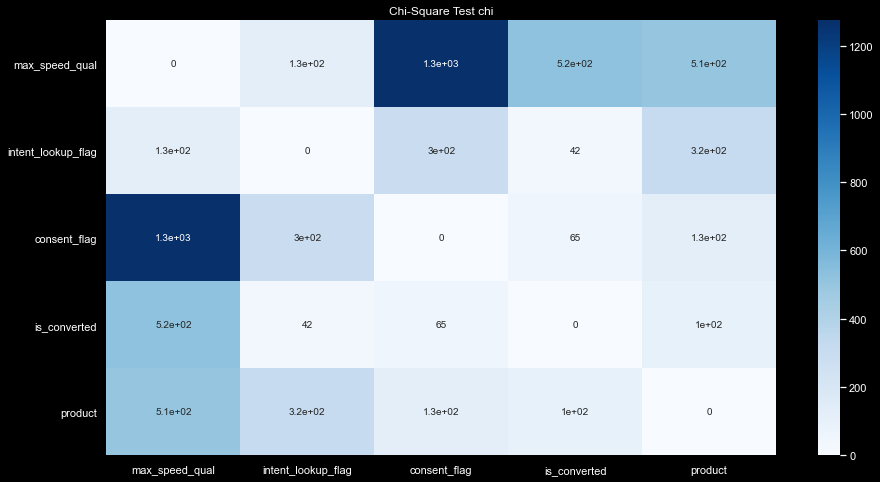

In [25]:
fig = plt.figure(figsize=(15,8))
sns.heatmap(resultant_chi, annot=True, cmap='Blues')
plt.title('Chi-Square Test chi')
plt.show()

__Observations:__

- `product` does not seem to be indenpent of `max_speed_qual`, `intent`, `consent`, and `is_converted`.
- `max_speed_qual` is related to internet, hence the dependece is understandable. This hence indicats the duplication/collinearity if `product` was to be added as an independent variable. 

In [26]:
conf = 0.95
chi, p, dof, expected = chi2_contingency(pd.crosstab(df['product'], df['is_converted']))
critical_value = chi2_2.ppf(conf, dof)

print('chi=%.6f, critical value=%.6f\n' % (chi, critical_value))
if chi > critical_value:
    print("""At %.2f level of significance, we reject the null hypotheses and accept H1. 
They are not independent.""" % (1-conf))
else:
    print("""At %.2f level of significance, we accept the null hypotheses. 
They are independent.""" % (1-conf))

chi=103.306189, critical value=9.487729

At 0.05 level of significance, we reject the null hypotheses and accept H1. 
They are not independent.


In [27]:
conf = 0.95
chi, p, dof, expected = chi2_contingency(pd.crosstab(df['product'], df['max_speed_qual']))
critical_value = chi2_2.ppf(conf, dof)

print('chi=%.6f, critical value=%.6f\n' % (chi, critical_value))
if chi > critical_value:
    print("""At %.2f level of significance, we reject the null hypotheses and accept H1. 
They are not independent.""" % (1-conf))
else:
    print("""At %.2f level of significance, we accept the null hypotheses. 
They are independent.""" % (1-conf))

chi=506.755559, critical value=65.170769

At 0.05 level of significance, we reject the null hypotheses and accept H1. 
They are not independent.


In [28]:
conf = 0.95
chi, p, dof, expected = chi2_contingency(pd.crosstab(df['product'], df['intent_lookup_flag']))
critical_value = chi2_2.ppf(conf, dof)

print('chi=%.6f, critical value=%.6f\n' % (chi, critical_value))
if chi > critical_value:
    print("""At %.2f level of significance, we reject the null hypotheses and accept H1. 
They are not independent.""" % (1-conf))
else:
    print("""At %.2f level of significance, we accept the null hypotheses. 
They are independent.""" % (1-conf))

chi=321.770417, critical value=15.507313

At 0.05 level of significance, we reject the null hypotheses and accept H1. 
They are not independent.


<a id='conclusion'>  </a>

# Conclusion

__Product interest does not seem to be a good candidate for predicting conversion. Reasons are given as follows:__

- Product interest does not seem to be independent of multiple current independent variables. The association between product interest and `max_speed_qual` is expected. 
- Based on the chi-square test, adding product interest could worsen the multilinearity problem (which exists currently), ultimately reduce the power of the model and make it hard to intrpret. 